# Your Title Here

**Name(s)**: Tom Hocquet and Julia Ma

**Website Link**: https://tomok59.github.io/power_outages/

## Code

In [1]:
import pandas as pd
import numpy as np
import os
import folium
import requests
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import tabulate

import plotly.express as px
pd.options.plotting.backend = 'plotly'

### Cleaning and EDA

In [2]:
df = pd.read_excel('outage.xlsx', header=5)
df = df.drop([0]).drop(columns='variables').set_index('OBS')
df_dropped = df.dropna(subset=['OUTAGE.START.TIME'])
df_dropped = df_dropped.dropna(subset=['OUTAGE.RESTORATION.TIME'])
temp = pd.to_timedelta(df_dropped['OUTAGE.START.TIME'].astype(str))
df_dropped['OUTAGE.START'] = df_dropped['OUTAGE.START.DATE'] + temp
temp = pd.to_timedelta(df_dropped['OUTAGE.RESTORATION.TIME'].astype(str))
df_dropped['OUTAGE.RESTORATION'] = df_dropped['OUTAGE.RESTORATION.DATE'] + temp
df_dropped['YEAR'] = df_dropped['YEAR'].astype(int)
df_dropped['MONTH'] = df_dropped['MONTH'].astype(int)
print(df_dropped.reset_index()[['YEAR', 'MONTH', 'U.S._STATE', 'OUTAGE.START.DATE', 'OUTAGE.DURATION']].head().to_markdown())

|    |   YEAR |   MONTH | U.S._STATE   | OUTAGE.START.DATE   |   OUTAGE.DURATION |
|---:|-------:|--------:|:-------------|:--------------------|------------------:|
|  0 |   2011 |       7 | Minnesota    | 2011-07-01 00:00:00 |              3060 |
|  1 |   2014 |       5 | Minnesota    | 2014-05-11 00:00:00 |                 1 |
|  2 |   2010 |      10 | Minnesota    | 2010-10-26 00:00:00 |              3000 |
|  3 |   2012 |       6 | Minnesota    | 2012-06-19 00:00:00 |              2550 |
|  4 |   2015 |       7 | Minnesota    | 2015-07-18 00:00:00 |              1740 |


/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(
/Users/demo/anaconda3/envs/dsc80/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1187: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


In [3]:
df.groupby('CAUSE.CATEGORY').count()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
CAUSE.CATEGORY,,,,,,,,,,,,,,,,,,,,,
equipment failure,60,57,60,60,60,59,57,57,57,57,...,60,60,60,59,59,60,60,60,60,60
fuel supply emergency,51,50,51,51,51,51,50,50,50,50,...,51,51,51,51,51,51,51,51,51,51
intentional attack,418,418,418,418,418,418,418,418,418,418,...,418,418,418,418,418,418,418,418,418,418
islanding,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
public appeal,69,69,69,69,69,69,69,69,69,69,...,69,69,69,69,69,69,69,69,69,69
severe weather,763,759,763,763,763,759,759,759,759,759,...,763,763,763,754,754,763,763,763,763,763
system operability disruption,127,126,127,127,127,126,126,126,126,126,...,127,127,127,127,127,127,127,127,127,127


In [4]:
pd.DataFrame(df.groupby('NERC.REGION')['YEAR'].count())

,YEAR
NERC.REGION,
ASCC,1
ECAR,34
FRCC,44
"FRCC, SERC",1
HECO,3
HI,1
MRO,46
NPCC,150
PR,1


## Univariate Graphes

In [5]:
df_dropped.groupby(['CAUSE.CATEGORY','YEAR']).count()['MONTH'].unstack(level=0).plot(kind='bar')

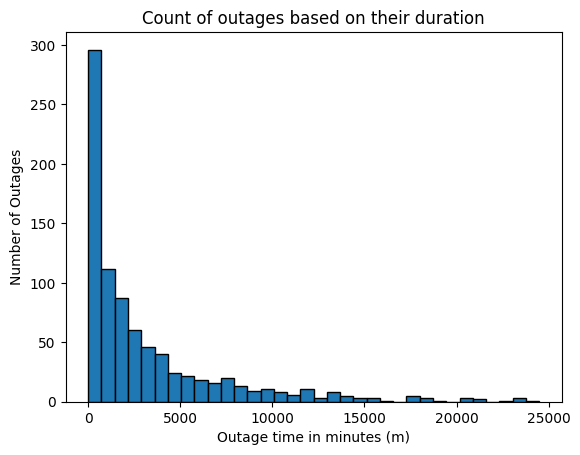

Each grouping represents 12 hour period, or half a day.


In [6]:
graph2 = df_dropped.groupby('OUTAGE.DURATION').count().reset_index()#['MONTH']#.plot(kind='hist')
w = 12*60
plt.hist(graph2['OUTAGE.DURATION'], bins=np.arange(min(graph2['OUTAGE.DURATION']), 25000, w), edgecolor='black', rwidth=500)
plt.xlabel('Outage time in minutes (m)')
plt.ylabel('Number of Outages')
plt.title('Count of outages based on their duration')
plt.savefig('power_outages/assets/outage-duration-hist4.png', format='png')
plt.show()
print('Each grouping represents 12 hour period, or half a day.')

In [7]:
temp_df = pd.DataFrame(df_dropped.groupby('MONTH', dropna=True)['OUTAGE.DURATION'].mean())

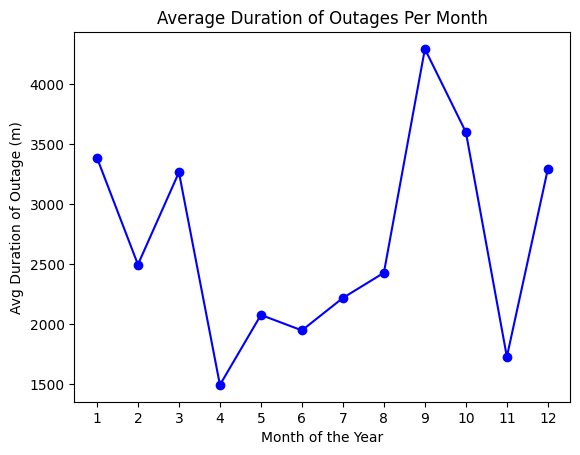

In [8]:
plt.figure()
plt.plot(temp_df.index, temp_df['OUTAGE.DURATION'], color='blue', marker='o')
plt.xticks(np.arange(1, 13, step=1))
plt.xlabel("Month of the Year")
plt.ylabel("Avg Duration of Outage (m)")
plt.title("Average Duration of Outages Per Month")
plt.savefig('power_outages/assets/outage-duration-line.png', format='png')
plt.show()

In [9]:
over_time_df = df_dropped.groupby(['OUTAGE.START'], dropna=True)['OUTAGE.DURATION'].count().plot()
over_time_df

In [10]:
pd.DataFrame(df_dropped.groupby(['CAUSE.CATEGORY','CAUSE.CATEGORY.DETAIL'])['YEAR'].count())


YEAR
CAUSE.CATEGORY                CAUSE.CATEGORY.DETAIL          
equipment failure             breaker trip                  4
                              cables                        1
                              computer hardware             1
                              feeder shutdown               1
                              generator trip               16
                              line fault                    1
                              plant trip                    1
                              relaying malfunction          1
                              substation                    2
                              switching                     2
                              transformer outage            2
                              transmission                  3
                              transmission interruption     2
                              transmission trip             6
fuel supply emergency          Coal                         7
                               Hydro                        1
                               Natural Gas                  7
                              Coal                          6
                              Hydro                         3
                              Petroleum                     1
intentional attack            sabotage                     29
                              suspicious activity           3
                              vandalism                   325
severe weather                earthquake                    4
                              flooding                      4
                              fog                           1
                              hailstorm                     3
                              heatwave                     10
                              heavy wind                   60
                              hurricanes                   73
                              lightning                     3
                              public appeal                 1
                              snow/ice                     13
                              snow/ice storm                1
                              storm                        41
                              thunderstorm                176
                              thunderstorm; islanding       1
                              tornadoes                     8
                              uncontrolled loss             2
                              wildfire                     23
                              wind                          2
                              wind storm                    6
                              wind/rain                    12
                              winter                       23
                              winter storm                100
system operability disruption 100 MW loadshed               1
                              HVSubstation interruption     1
                              distribution interruption     2
                              majorsystem interruption      1
                              shed load                     1
                              transmission interruption    17
                              uncontrolled loss            12
                              voltage reduction             1

## Bivarate Graph

In [11]:
df_dropped.groupby(['U.S._STATE','OUTAGE.DURATION']).count().unstack(level=1)['YEAR'].sum(axis=1).plot(kind='bar')

In [12]:
state_data = df_dropped[["U.S._STATE", "POSTAL.CODE", "OUTAGE.DURATION"]].groupby(['POSTAL.CODE','U.S._STATE']).mean()
state_data = state_data.reset_index()

state_geo = requests.get(
    "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json"
).json()
geo_merge = pd.DataFrame(state_geo['features'])
state_data = state_data.merge(geo_merge, left_on='POSTAL.CODE', right_on="id")

In [13]:
## GRAPHS/STATS I MADE BUT I DONT THINK ARE NEEDED NOW

#df_dropped.groupby(['U.S._STATE','OUTAGE.DURATION']).count().unstack(level=0)['MONTH'].plot(kind='bar')
#df_dropped.groupby('UTIL.CONTRI').count()
#df_dropped.groupby(['CAUSE.CATEGORY','CAUSE.CATEGORY.DETAIL']).count()

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=["POSTAL.CODE", "OUTAGE.DURATION"],
    key_on="feature.id",
    #fill_color="YlGn",
    fill_opacity=0.9,
    line_opacity=0.2,
    bins=[0, 500, 1000, 2000, 4000, 6000, 8000],
    highlight=True,
    legend_name="Mean Duration of Outage per State",
    nan_fill_color="purple"
).add_to(m)
m.save('map.html')

In [14]:

### TRY TO ADD HIGHLIGHT FUNCTION THAT WORKS###

# style_function = lambda x: {'fillColor': '#ffffff', 
#                             'color':'#000000', 
#                             'fillOpacity': 0.1, 
#                             'weight': 0.1}
# highlight_function = lambda x: {'fillColor': '#000000', 
#                                 'color':'#000000', 
#                                 'fillOpacity': 0.50, 
#                                 'weight': 0.1}
# NIL = folium.features.GeoJson(
#     state_data,
#     style_function=style_function, 
#     control=False,
#     highlight_function=highlight_function, 
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=["POSTAL.CODE", "OUTAGE.DURATION"],
#         aliases=['STATE: ','Duration of Outage'],
#         style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
#     )
# )
# m.add_child(NIL)
# m.keep_in_front(NIL)
# folium.LayerControl().add_to(m)
# m

## Interesting AGG 

In [15]:
#df_dropped.groupby('MONTH', dropna=True).agg()
df_dropped.groupby(['OUTAGE.START'])['ANOMALY.LEVEL'].mean().plot(kind='scatter')

In [16]:
df_dropped.groupby(['ANOMALY.LEVEL']).count()

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
ANOMALY.LEVEL,,,,,,,,,,,,,,,,,,,,,
-1.6,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
-1.5,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
-1.4,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
-1.3,35,35,35,35,35,35,35,35,35,35,...,35,34,34,35,35,35,35,35,35,35
-1.2,13,13,13,13,13,13,13,13,13,13,...,13,11,11,13,13,13,13,13,13,13
-1.1,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
-1.0,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
-0.9,54,54,54,54,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
-0.8,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20


In [17]:
df_cause = df_dropped[['CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL']]
df_cause = pd.get_dummies(df_cause, columns=['CAUSE.CATEGORY.DETAIL'], dummy_na=True, prefix='CAUSE.CATEGORY.DETAIL')
df_cause.groupby('CAUSE.CATEGORY').agg('sum').plot(kind='bar')
#df_cause

In [18]:
df_cause.reset_index().drop(columns='OBS')#.sum(axis=0)

,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL_ Coal,CAUSE.CATEGORY.DETAIL_ Hydro,CAUSE.CATEGORY.DETAIL_ Natural Gas,CAUSE.CATEGORY.DETAIL_100 MW loadshed,CAUSE.CATEGORY.DETAIL_Coal,CAUSE.CATEGORY.DETAIL_HVSubstation interruption,CAUSE.CATEGORY.DETAIL_Hydro,CAUSE.CATEGORY.DETAIL_Petroleum,CAUSE.CATEGORY.DETAIL_breaker trip,...,CAUSE.CATEGORY.DETAIL_uncontrolled loss,CAUSE.CATEGORY.DETAIL_vandalism,CAUSE.CATEGORY.DETAIL_voltage reduction,CAUSE.CATEGORY.DETAIL_wildfire,CAUSE.CATEGORY.DETAIL_wind,CAUSE.CATEGORY.DETAIL_wind storm,CAUSE.CATEGORY.DETAIL_wind/rain,CAUSE.CATEGORY.DETAIL_winter,CAUSE.CATEGORY.DETAIL_winter storm,CAUSE.CATEGORY.DETAIL_nan
0,severe weather,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,intentional attack,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,severe weather,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,severe weather,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,severe weather,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,intentional attack,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1472,system operability disruption,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1473,public appeal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1474,islanding,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Assessment of Missingness

In [19]:
df_cleaned = df_dropped

In [20]:
# checking how many NaNs each column has 
nan_dict = {
            'column name': [],
            'missing data amount': []
            }

for column in df.columns:
    if df[column].isna().sum() != 0:
        nan_dict['column name'] += [column]
        nan_dict['missing data amount'] += [df[column].isna().sum()]
        # print(column, ":", str(df[column].isna().sum()))

nan_df = pd.DataFrame(nan_dict)
nan_df = nan_df.set_index('column name').sort_values('missing data amount', ascending = False)
nan_df['missing data amount'] = round(nan_df['missing data amount'] / df_cleaned.shape[0], 2)
nan_df.head(5)

,missing data amount
column name,
HURRICANE.NAMES,0.99
DEMAND.LOSS.MW,0.48
CAUSE.CATEGORY.DETAIL,0.32
CUSTOMERS.AFFECTED,0.30
OUTAGE.RESTORATION.DATE,0.04


In [21]:
# dropping more columns that aren't relevant
# since there are a lot of columns to work with (55), then we need to drop the ones that aren't relevant to our analysis to make our dataframe cleaner  
cause_df = df_cleaned[['CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL']]
cause_df = cause_df.assign(DETAIL_MISSING = cause_df['CAUSE.CATEGORY.DETAIL'].isna())

In [22]:
# creating pivot table 

cause_category_dist = (
    cause_df
    #.assign(DETAIL_MISSING=selected_df['CAUSE.CATEGORY.DETAIL'].isna())
    .pivot_table(index='CAUSE.CATEGORY', columns='DETAIL_MISSING', aggfunc='size')
)

# Added just to make the resulting pivot table easier to read.
cause_category_dist.columns = ['DETAIL_MISSING = False', 'DETAIL_MISSING = True']

cause_category_dist = cause_category_dist / cause_category_dist.sum()
cause_category_dist

,DETAIL_MISSING = False,DETAIL_MISSING = True
CAUSE.CATEGORY,,
equipment failure,0.041829,0.026786
fuel supply emergency,0.024319,0.029018
intentional attack,0.347276,0.102679
islanding,NaN,0.098214
public appeal,NaN,0.154018
severe weather,0.551556,0.395089
system operability disruption,0.035019,0.194196


In [23]:
cause_category_dist.plot(kind='barh', title='Cause Category by Missingness in Detail', barmode='group')

In [24]:
# permutation test 
# simulation

n_repetitions = 500
shuffled_categories = cause_df.copy()

shuffled_categories

tvds = []
for _ in range(n_repetitions):
    
    # Shuffling genders. 
    # Note that we are assigning back to the same DataFrame for performance reasons; 
    # see https://dsc80.com/resources/lectures/lec11/lec11-fast-permutation-tests.html.
    shuffled_categories['CAUSE.CATEGORY'] = np.random.permutation(shuffled_categories['CAUSE.CATEGORY'])
    
    # Computing and storing the TVD.
    pivoted = (
        shuffled_categories
        .pivot_table(index='CAUSE.CATEGORY', columns='DETAIL_MISSING', aggfunc='size')
        .apply(lambda x: x / x.sum())
    )
    
    tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds.append(tvd)

# observed tvd
observed_tvd = cause_category_dist.diff(axis=1).iloc[:, -1].abs().sum() / 2

# results
fig = px.histogram(pd.DataFrame(tvds), x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the TVD')
fig.add_vline(x=observed_tvd, line_color='red')
fig.add_annotation(text=f'<span style="color:red">Observed TVD = {round(observed_tvd, 2)}</span>',
                   x=2.3 * observed_tvd, showarrow=False, y=0.16)
fig.update_layout(yaxis_range=[0, 0.2])

In [25]:
p_val = np.mean(np.array(tvds) >= observed_tvd)
p_val

0.0

In [26]:
price_df = df_cleaned[['IND.PRICE', 'CAUSE.CATEGORY.DETAIL']]
price_df = price_df.assign(QcutBin = pd.qcut(price_df['IND.PRICE'], q=5))

price_df = price_df.assign(DETAIL_MISSING = price_df['CAUSE.CATEGORY.DETAIL'].isna())
price_df['QcutBin'] = price_df['QcutBin'].astype('str')

In [27]:
# creating pivot table 
dist = (
    price_df
    #.assign(DETAIL_MISSING=selected_df['CAUSE.CATEGORY.DETAIL'].isna())
    .pivot_table(index='QcutBin', columns='DETAIL_MISSING', aggfunc='size')
)

# Added just to make the resulting pivot table easier to read.
dist.columns = ['DETAIL_MISSING = False', 'DETAIL_MISSING = True']

dist = dist / dist.sum()
dist

,DETAIL_MISSING = False,DETAIL_MISSING = True
QcutBin,,
"(3.1990000000000003, 5.48]",0.224708,0.162946
"(5.48, 6.3]",0.197471,0.187500
"(6.3, 7.32]",0.190661,0.212054
"(7.32, 9.114]",0.189689,0.209821
"(9.114, 27.85]",0.191634,0.214286
nan,0.005837,0.013393


In [28]:
info_graph = dist.plot(kind='barh', title='TOTAL.CUSTOMERS by Missingness in Detail', barmode='group')
info_graph

In [29]:
# permutation test 
# simulation

shuffled = price_df.copy()
shuffled

tvds = []
for _ in range(n_repetitions):
    
    # Shuffling categories. 
    # Note that we are assigning back to the same DataFrame for performance reasons; 
    # see https://dsc80.com/resources/lectures/lec11/lec11-fast-permutation-tests.html.
    shuffled['IND.PRICE'] = np.random.permutation(shuffled['IND.PRICE'])
    
    # Computing and storing the TVD.
    pivoted = (
        shuffled
        .pivot_table(index='IND.PRICE', columns='DETAIL_MISSING', aggfunc='size')
        .apply(lambda x: x / x.sum())
    )
    pivoted.columns = ['DETAIL_MISSING = False', 'DETAIL_MISSING = True']
    
    tvd = pivoted.diff(axis=1).iloc[:, -1].abs().sum() / 2
    tvds.append(tvd)

#observed tvd
observed_tvd = dist.diff(axis=1).iloc[:, -1].abs().sum() / 2

# histogram plot
# results
fig = px.histogram(pd.DataFrame(tvds), x=0, nbins=50, histnorm='probability', 
                title='Empirical Distribution of the TVD')
fig.add_vline(x=observed_tvd, line_color='red')
fig.add_annotation(text=f'<span style="color:red">Observed TVD = {round(observed_tvd, 2)}</span>',
                x=2.3 * observed_tvd, showarrow=False, y=0.16)
fig.update_layout(yaxis_range=[0, 0.2])
fig.write_html('dist-tvd2.html', include_plotlyjs='cdn')
fig.show()


# p val
p_val = np.mean(np.array(tvds) >= observed_tvd)
p_val


1.0

# Hypothesis Testing

Null Hypothesis ($H_0$): There is a correlation between the two variables.

Alternative Hypothesis ($H_A$): There is no correlation between the two variables.

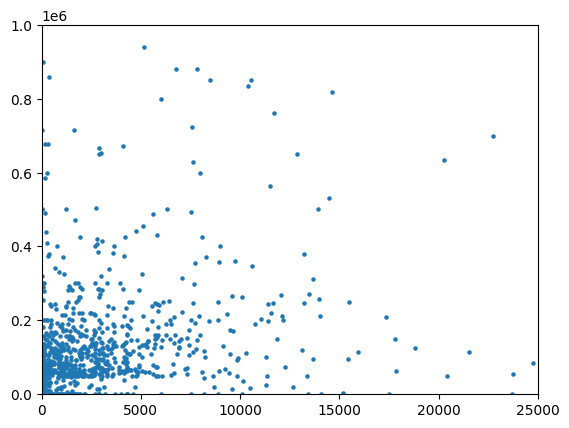

some values are not shown on the graph in order to see more details where the bulk of the data is


In [30]:
plt.scatter(df['OUTAGE.DURATION'], df['CUSTOMERS.AFFECTED'], s=5)
plt.xlim(0, 25000)
plt.ylim(0, 1000000)
plt.show()
print('some values are not shown on the graph in order to see more details where the bulk of the data is')

In [31]:
df_hypothesis = df[['OUTAGE.DURATION', 'CUSTOMERS.AFFECTED']].dropna()
df_hypothesis

,OUTAGE.DURATION,CUSTOMERS.AFFECTED
OBS,,
1.0,3060,70000.0
3.0,3000,70000.0
4.0,2550,68200.0
5.0,1740,250000.0
6.0,1860,60000.0
...,...,...
1523.0,95,35000.0
1524.0,360,0.0
1525.0,1548,0.0


In [32]:
scipy.stats.pearsonr(df_hypothesis['OUTAGE.DURATION'], df_hypothesis['CUSTOMERS.AFFECTED'])
#p_value, correlation

PearsonRResult(statistic=0.2619155954835712, pvalue=5.03140871848003e-18)

In [33]:
df_copy = df_hypothesis.copy()
df_copy['CUSTOMERS.AFFECTED'] = np.random.permutation(df_copy['CUSTOMERS.AFFECTED'])
df_copy

,OUTAGE.DURATION,CUSTOMERS.AFFECTED
OBS,,
1.0,3060,0.0
3.0,3000,492955.0
4.0,2550,0.0
5.0,1740,1200.0
6.0,1860,0.0
...,...,...
1523.0,95,200000.0
1524.0,360,68018.0
1525.0,1548,65562.0


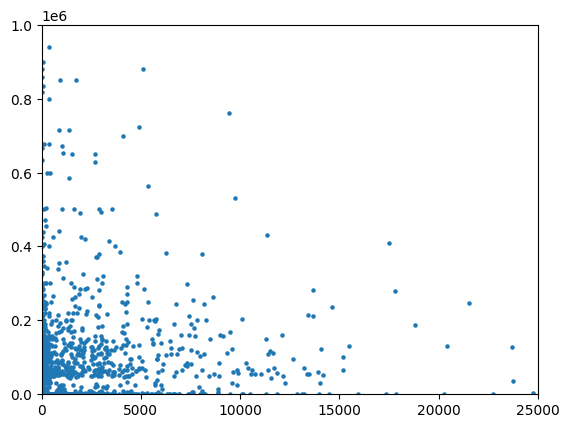

In [34]:
plt.scatter(df_copy['OUTAGE.DURATION'], df_copy['CUSTOMERS.AFFECTED'], s=5)
plt.xlim(0, 25000)
plt.ylim(0, 1000000)
plt.show()

In [35]:
df = df.apply(pd.to_numeric, errors='ignore')
numeric_df = df.select_dtypes(include='number')
numeric_df.dtypes

YEAR                  float64
MONTH                 float64
ANOMALY.LEVEL         float64
OUTAGE.DURATION       float64
DEMAND.LOSS.MW        float64
CUSTOMERS.AFFECTED    float64
RES.PRICE             float64
COM.PRICE             float64
IND.PRICE             float64
TOTAL.PRICE           float64
RES.SALES             float64
COM.SALES             float64
IND.SALES             float64
TOTAL.SALES           float64
RES.PERCEN            float64
COM.PERCEN            float64
IND.PERCEN            float64
RES.CUSTOMERS         float64
COM.CUSTOMERS         float64
IND.CUSTOMERS         float64
TOTAL.CUSTOMERS       float64
RES.CUST.PCT          float64
COM.CUST.PCT          float64
IND.CUST.PCT          float64
PC.REALGSP.STATE        int64
PC.REALGSP.USA          int64
PC.REALGSP.REL        float64
PC.REALGSP.CHANGE     float64
UTIL.REALGSP            int64
TOTAL.REALGSP           int64
UTIL.CONTRI           float64
PI.UTIL.OFUSA         float64
POPULATION            float64
POPPCT_URB

In [36]:
df['SQUARE.MILES.AFFECTED'] = df['CUSTOMERS.AFFECTED']/df['POPDEN_UC']
df

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,SQUARE.MILES.AFFECTED
OBS,,,,,,,,,,,,,,,,,,,,,
1.0,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01,17:00:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,41.164363
2.0,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11,18:38:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,NaN
3.0,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26,20:00:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,41.164363
4.0,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19,04:30:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,40.105851
5.0,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18,02:00:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,147.015584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530.0,2011.0,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,2011-12-06,08:00:00,...,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,18.466974
1531.0,2006.0,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,NaT,NaN,...,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,NaN
1532.0,2009.0,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,2009-08-29,22:54:00,...,26.73,2038.3,1905.4,4.7,0.30,0.15,98.307744,1.692256,1.692256,NaN


In [37]:
numeric_df = df.select_dtypes(include='number')
numeric_df = numeric_df[['SQUARE.MILES.AFFECTED', 'OUTAGE.DURATION']]
df_num_drop = numeric_df[['SQUARE.MILES.AFFECTED', 'OUTAGE.DURATION']].dropna()
df_num_drop

,SQUARE.MILES.AFFECTED,OUTAGE.DURATION
OBS,,
1.0,41.164363,3060.0
3.0,41.164363,3000.0
4.0,40.105851,2550.0
5.0,147.015584,1740.0
6.0,35.283740,1860.0
...,...,...
1523.0,17.458971,95.0
1524.0,0.000000,360.0
1525.0,0.000000,1548.0


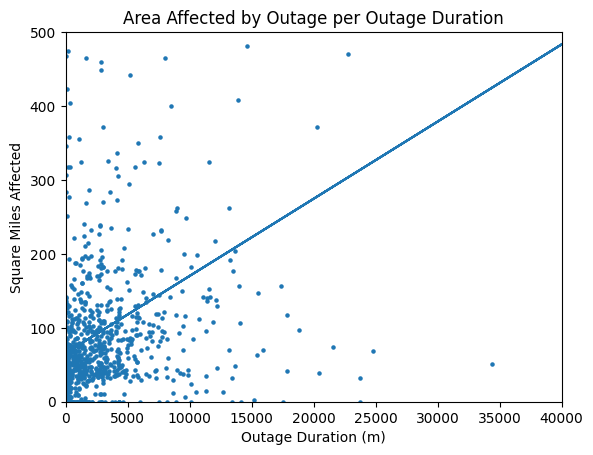

In [38]:
plt.scatter(df_num_drop['OUTAGE.DURATION'], df_num_drop['SQUARE.MILES.AFFECTED'], s=5)
plt.xlim(0, 40000)
plt.ylim(0, 500)
a, b= np.polyfit(df_num_drop['OUTAGE.DURATION'], df_num_drop['SQUARE.MILES.AFFECTED'], 1)
plt.plot(df_num_drop['OUTAGE.DURATION'], a*df_num_drop['OUTAGE.DURATION']+b)
plt.xlabel('Outage Duration (m)')
plt.ylabel('Square Miles Affected')
plt.title('Area Affected by Outage per Outage Duration')
plt.savefig('hypo1.png')
plt.show()

In [39]:
df_num_drop

,SQUARE.MILES.AFFECTED,OUTAGE.DURATION
OBS,,
1.0,41.164363,3060.0
3.0,41.164363,3000.0
4.0,40.105851,2550.0
5.0,147.015584,1740.0
6.0,35.283740,1860.0
...,...,...
1523.0,17.458971,95.0
1524.0,0.000000,360.0
1525.0,0.000000,1548.0


In [40]:

x = df_num_drop['OUTAGE.DURATION']
y = df_num_drop['SQUARE.MILES.AFFECTED']
observed_correlation, _ = scipy.stats.pearsonr(x, y)

# Number of permutations
num_permutations = 100000

# # Permutation test
permuted_correlations = []
for i in range(num_permutations):
    permuted_y = np.random.permutation(y)
    permuted_correlation, _ = scipy.stats.pearsonr(x, permuted_y)
    permuted_correlations.append(permuted_correlation)

# # Calculate p-value
p_value = (np.abs(permuted_correlations) >= np.abs(observed_correlation)).mean()

# # Display the p-value
# print(f'Permutation Test P-value: {p_value}')

In [41]:
observed_correlation

0.2419610934765804

In [42]:
p_value

1e-05

(array([3.9000e+01, 7.0100e+02, 5.2590e+03, 1.5548e+04, 2.3558e+04,
        2.2681e+04, 1.5584e+04, 8.7150e+03, 4.1830e+03, 1.9980e+03,
        9.0500e+02, 4.4000e+02, 2.2200e+02, 1.0200e+02, 3.4000e+01,
        2.0000e+01, 7.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-0.09370711, -0.07636866, -0.0590302 , -0.04169175, -0.02435329,
        -0.00701484,  0.01032362,  0.02766207,  0.04500053,  0.06233898,
         0.07967743,  0.09701589,  0.11435434,  0.1316928 ,  0.14903125,
         0.16636971,  0.18370816,  0.20104662,  0.21838507,  0.23572352,
         0.25306198]),
 <BarContainer object of 20 artists>)

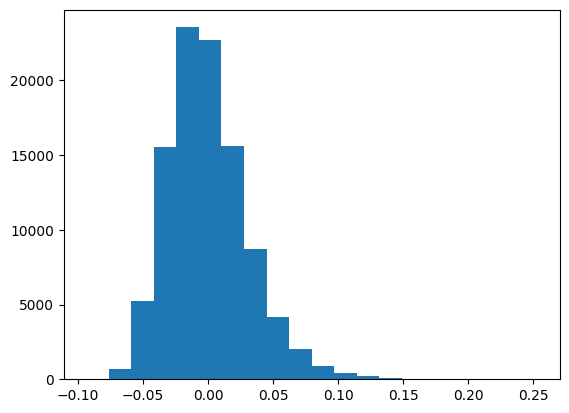

In [43]:
plt.hist(permuted_correlations, bins=20)

In [44]:
fig = px.histogram(pd.DataFrame(permuted_correlations), x=0, nbins=50, histnorm='probability', 
                   title='Distribution of Pearsons Correlation Coefficiant')
fig.add_vline(x=observed_correlation, line_color='red')
fig.add_annotation(text=f'<span style="color:red">Observed Pearsons Correlation Coefficiant = {round(observed_correlation, 2)}</span>',
                   x=2.3 * observed_correlation, showarrow=False, y=0.16)
fig.update_layout(yaxis_range=[0, 0.15])
fig.write_html('hypo2.html', include_plotlyjs='cdn')
fig.show()

In [45]:
df.dtypes

YEAR                              float64
MONTH                             float64
U.S._STATE                         object
POSTAL.CODE                        object
NERC.REGION                        object
CLIMATE.REGION                     object
ANOMALY.LEVEL                     float64
CLIMATE.CATEGORY                   object
OUTAGE.START.DATE          datetime64[ns]
OUTAGE.START.TIME                  object
OUTAGE.RESTORATION.DATE    datetime64[ns]
OUTAGE.RESTORATION.TIME            object
CAUSE.CATEGORY                     object
CAUSE.CATEGORY.DETAIL              object
HURRICANE.NAMES                    object
OUTAGE.DURATION                   float64
DEMAND.LOSS.MW                    float64
CUSTOMERS.AFFECTED                float64
RES.PRICE                         float64
COM.PRICE                         float64
IND.PRICE                         float64
TOTAL.PRICE                       float64
RES.SALES                         float64
COM.SALES                         

In [46]:
df = df.apply(pd.to_numeric, errors='ignore')

df.dtypes

In [47]:
print(df.dtypes.to_markdown())


|                         | 0       |
|:------------------------|:--------|
| YEAR                    | float64 |
| MONTH                   | float64 |
| U.S._STATE              | object  |
| POSTAL.CODE             | object  |
| NERC.REGION             | object  |
| CLIMATE.REGION          | object  |
| ANOMALY.LEVEL           | float64 |
| CLIMATE.CATEGORY        | object  |
| OUTAGE.START.DATE       | int64   |
| OUTAGE.START.TIME       | object  |
| OUTAGE.RESTORATION.DATE | int64   |
| OUTAGE.RESTORATION.TIME | object  |
| CAUSE.CATEGORY          | object  |
| CAUSE.CATEGORY.DETAIL   | object  |
| HURRICANE.NAMES         | object  |
| OUTAGE.DURATION         | float64 |
| DEMAND.LOSS.MW          | float64 |
| CUSTOMERS.AFFECTED      | float64 |
| RES.PRICE               | float64 |
| COM.PRICE               | float64 |
| IND.PRICE               | float64 |
| TOTAL.PRICE             | float64 |
| RES.SALES               | float64 |
| COM.SALES               | float64 |
| IND.SALES 

In [48]:
df

,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,...,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,SQUARE.MILES.AFFECTED
OBS,,,,,,,,,,,,,,,,,,,,,
1.0,2011.0,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,1309478400000000000,17:00:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,41.164363
2.0,2014.0,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,1399766400000000000,18:38:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,NaN
3.0,2010.0,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,1288051200000000000,20:00:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,41.164363
4.0,2012.0,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,1340064000000000000,04:30:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,40.105851
5.0,2015.0,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,1437177600000000000,02:00:00,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,147.015584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530.0,2011.0,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,1323129600000000000,08:00:00,...,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,18.466974
1531.0,2006.0,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,-9223372036854775808,NaN,...,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,NaN
1532.0,2009.0,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,1251504000000000000,22:54:00,...,26.73,2038.3,1905.4,4.7,0.30,0.15,98.307744,1.692256,1.692256,NaN
